## Implications of surface flooding on airborne estimates of snow depth on sea ice

https://tc.copernicus.org/articles/15/2819/2021/

Code suporting analyses and figures 5, 6, 7 and 8

**Adam Steer**: finalised this Jupyter notebook, revised all code and equations, implemented Cartopy as a coordinate transformation and mapping backend

**Anja Roesel** initial code contribution and data preprocessing


### Glossary

**atm** : airborne thematic mapper, another word for the instrument package used on ICEbridge flights. Below we use only the lidar component

**mp** : Magnaprobe - a semiautomated GPS snow depth probe produced by Snowhydro (http://www.snowhydro.com/products/column2.html)

**EM31** : an electromagnetic induction sounding instrument, the geonics EM31 (an older version of http://www.geonics.com/html/em31-mk2.html)

### Required python modules

In [2]:
import os,sys,glob

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path

from scipy import stats
from scipy.interpolate import griddata

In [3]:
#cartopy parts
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

In [4]:
# for figure sizing
cm = 1/2.54

In [5]:
# proj
from pyproj import CRS, transformer
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info


def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    return utm_crs_list[0].code

### Define sea ice freeboard and thickness models

These are the basic models used to find sea ice thickness and freeboard given surface elevation, snow depth and some density parameters - and assuming hydrostatic equilibrium.

These are listed in the order presented in the manuscript

In [6]:
# eqn 1: estimate ice thickness without a snow component from co-located snow probe and EM31 observations
def em_zi(em, sp):
    
    zi = em-sp
    
    return zi

# eqn 2, for completeness...
# from here, which also has VCV propagation for uncertainty estimation:
# https://gist.github.com/adamsteer/1aaf5e92f87d182928e3

def compute_zi(fs, zs, d_water, d_ice, d_snow):
    '''
    sea ice thickness from elevation after Kwok, 2010; kwok and cunningham, 2008
    '''
    zi = (d_water / (d_water-d_ice)) * fs - ((d_water-d_snow) / \
         (d_water - d_ice)) * zs
    
    return zi

# eqn 3: estimate ice freeboard given snow depths and ice thickness
def find_fi(zi, zs, dwater, dice, dsnow):
    
    #derived from eqn 1 in Forrstrom et al (2011) by Claire Trenham, CSIRO, after checking my maths
    fi = (((dwater - dice) * zi) - dsnow * zs) / dwater
    
    return fi

# eqn 6: two part (snow + ice) ice thickness from total freeboard
def twopart_zi(zi, zs, dwater, dice, dsnow):
    
    #same as eqn 2, but input is Zi and Zs, not Fs and Zs - it should produce 
    # identical numbers
    zi = ((d_water * zi)/ (d_water - d_ice)) + ((d_snow * zs) / \
         (d_water - d_ice))
    
    return zi

### Setting up paths to data

In [7]:
# Data must be obtained from Anja Roesel - see publication for contact details.

data_basepath = '../roesel-2021-data/'

snowradar_pass1 = data_basepath + '20150319.SurveySite_Pass1.WAV_SnowDepth.26Sep17.xyz'
snowradar_pass2 = data_basepath + '20150319.SurveySite_Pass2.WAV_SnowDepth.26Sep17.xyz'
snowradar_pass3 = data_basepath + '20150319.SurveySite_Pass3.WAV_SnowDepth.26Sep17.xyz'

snowradar_3passes = data_basepath + '20150319.SurveySite_Pass1-3.WAV_SnowDepth.26Sep17.xyz'

lidar_pass2 = data_basepath + 'atm_ascii_20150319_rvlance.SurveySite_P2.xyz'
lidar_pass3 = data_basepath + 'atm_ascii_20150319_rvlance.SurveySite_P3.xyz'

em31_observations = data_basepath + '20150319NASA_res_drift_corr_cut.txt'
magnaprobe_observations = data_basepath + '2015_03_19_Nasa34_clean.txt'

drillhole_observations = data_basepath + 'drillholes.csv'

regional_mp_transect_dir = data_basepath + 'transects'
regional_mp_independent_dir = data_basepath + 'independent'

## Import the data

In [8]:
# start easy - drill hole observations
drillholes = np.genfromtxt(drillhole_observations, delimiter=',',skip_header=1, usecols=(4,5,6,7,8))

In [9]:
# read lidar data from 2nd overflight
atm_pass2 = np.genfromtxt(lidar_pass2 , delimiter=' ',skip_header=0)

lat_pass2=atm_pass2[:,0].astype(float)
lon_pass2=atm_pass2[:,1].astype(float)
elevation_pass2=atm_pass2[:,2].astype(float)

# read lidar data from 3rd overflight
atm_pass3 = np.genfromtxt(lidar_pass3 , delimiter='\t',skip_header=0)

lat_pass3=atm_pass3[:,0]
lon_pass3=atm_pass3[:,1]
elevation_pass3=atm_pass3[:,2]

In [10]:
# read snow radar observations
snowradar = np.genfromtxt(snowradar_3passes , delimiter=' ',skip_header=1)
snowdepth_radar = snowradar[:,2]
snow_radar_lat = snowradar[:,0]
snow_radar_lon = snowradar[:,1]

In [11]:
#read magnaprobe snow data from co-located airborne and insitu site
magnaprobe = np.genfromtxt(magnaprobe_observations, delimiter=';')
mp_snowdepths = magnaprobe[:,2].astype(float)
mp_lat = magnaprobe[:,5]
mp_lon = magnaprobe[:,6]
# convert snow depths to meters
snow_meters=np.array(mp_snowdepths)[~np.isnan(mp_snowdepths)]/100.

In [12]:
#read EM31 data from co-located insitu and airborne site
em31 = np.genfromtxt(em31_observations , delimiter=',',skip_header=1)  
em31_total_thickness=em31[:,2]
em31_lon = em31[:,0]
em31_lat = em31[:,1]

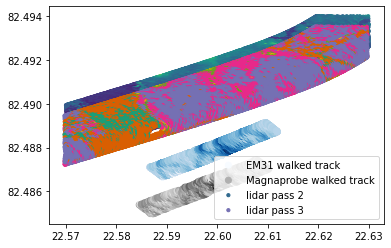

In [16]:
plt.scatter(em31_lon, em31_lat, c=em31_total_thickness, label = "EM31 walked track", cmap = "Blues")
plt.scatter(mp_lon, mp_lat, c=snow_meters, label = "Magnaprobe walked track", cmap="Greys")
plt.scatter(lon_pass2, lat_pass2, c=elevation_pass2, label = "lidar pass 2", s = 10)
plt.scatter(lon_pass3, lat_pass3, c=elevation_pass3, cmap='Dark2', label = "lidar pass 3", s = 10)
plt.legend()

### Get all the data into a common reference system - correct for ice drift

In [17]:
# make everything meters in north polar stereo

thetransform = transformer.Transformer.from_proj(4326,3413)

In [18]:
pass2_northpolar = np.array(thetransform.transform(lat_pass2, lon_pass2))
em31_northpolar = np.array(thetransform.transform(em31_lat,em31_lon))
mp_northpolar = np.array(thetransform.transform(mp_lat,mp_lon))
snowradar_northpolar = np.array(thetransform.transform(snow_radar_lat, snow_radar_lon))

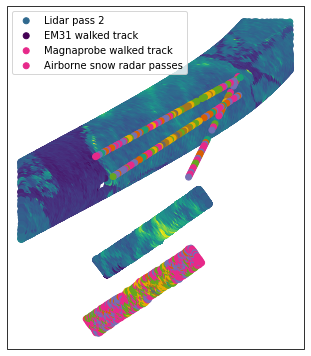

In [20]:
fig = plt.figure(figsize=(16*cm,16*cm))
ax1= fig.add_subplot(111, projection=ccrs.NorthPolarStereo(central_longitude=22.5, true_scale_latitude=70))

plt.scatter(pass2_northpolar[0], pass2_northpolar[1], c = elevation_pass2,
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "Lidar pass 2")
plt.scatter(em31_northpolar[0], em31_northpolar[1], c = em31_total_thickness,
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "EM31 walked track")
plt.scatter(mp_northpolar[0], mp_northpolar[1], c = snow_meters, cmap='Dark2',
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "Magnaprobe walked track")
plt.scatter(snowradar_northpolar[0], snowradar_northpolar[1], c = snowdepth_radar, cmap='Dark2',
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "Airborne snow radar passes")
plt.legend()

### Define insitu data collection bounds at lidar collection time, clip lidar inside the bounding box

In [21]:
##Corner Coords for the common survey patch, from 2nd overflight used for all driftcorrections
tl=[ 82.49219160, 22.61211125]
tr=[ 82.49174979, 22.61446261]
bl=[ 82.49021325, 22.58902901]
br=[ 82.48978518, 22.59157271]

##transform to meters in north polar stereographic, arranged in a ccw winding order
# (important for making a polygon in the next cell)

corner_lats = np.array([bl[0], br[0], tr[0], tl[0]])
corner_lons = np.array([bl[1], br[1], tr[1], tl[1]])

corners_northpolar = np.array(thetransform.transform(corner_lats, corner_lons))

corners_northpolar[0]

array([753107.76930981, 753164.6043064 , 753091.0183481 , 753033.85272273])

In [22]:
# create a matplotlib polygon path from the corners
cutpath = Path(np.transpose(corners_northpolar))

In [23]:
# slight suprise at not doing this yet - make array from pass2 lidar points
pass2_northpolar = np.array(pass2_northpolar)

In [24]:
# transpose the array so we have the right dimensions for matplotlib point in polygon finding
pass2_northpolar2 = np.transpose(pass2_northpolar)

In [25]:
# create a boolean mask for lidar points falling inside the polygon, returning an array 
# the same length as the lidar dateset containing true for points which are inside the polygon,
#, false for all other points

lidar_in_patch_mask = cutpath.contains_points(pass2_northpolar2)

In [26]:
# Use the mask to pick points which fall inside the polygon

lidar_in_patch = pass2_northpolar2[lidar_in_patch_mask]
elevation_in_patch = elevation_pass2[lidar_in_patch_mask]

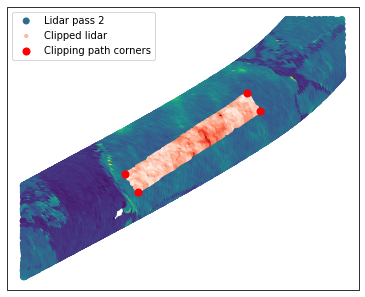

In [31]:
# check

fig = plt.figure(figsize=(16*cm,16*cm))
ax1= fig.add_subplot(111, projection=ccrs.NorthPolarStereo(central_longitude=22.5, true_scale_latitude=70))

ax1.scatter(pass2_northpolar[0], pass2_northpolar[1], c = elevation_pass2,
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
            label = "Lidar pass 2" )


ax1.scatter(lidar_in_patch[:,0], lidar_in_patch[:,1], c = elevation_in_patch, cmap="Reds",
            transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           s = 10, label = "Clipped lidar")

ax1.scatter(corners_northpolar[0], corners_northpolar[1], s=50,
            transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           c = 'Red', label = "Clipping path corners")

ax1.legend()

### Drift correction

Aligning EM soundings and magnaprobe snow depths with lidar and snow radar, by a planar (XY) translation using the bounding box above as the "to" translation.

Note that the translation will be accurate to around sub-meter level rather than the centimeter precision suggested by survey corner patch lat/lons. Also, the translation assumes no ice floe rotation.

In [33]:
# translate EM soundings


#find the index of the minimum Y coordinate of the mapgnaprobe dataset 
i=np.where(em31_northpolar[0] == em31_northpolar[0].min())

#get the difference in X and Y from the point here to the bottom right of the bounding
# at lidar time

# get the XY pair for the minimum Y value
br_em31_x = em31_northpolar[0][i]
br_em31_y = em31_northpolar[1][i]

# find the difference between the minimum XY pair in the MP coordinate list
# and the 'bottom' corner coord in npolar stereo
d_em_x = corners_northpolar[0][0] - br_em31_x
d_em_y = corners_northpolar[1][0] - br_em31_y

#translate MP coordinates by the offset found above
em31_x_dc = em31_northpolar[0] + d_em_x
em31_y_dc = em31_northpolar[1] + d_em_y

In [34]:
# translate Magnaprobe observations

#find the index of the minimum Y coordinate of the mapgnaprobe dataset 
i=np.where(mp_northpolar[1] == mp_northpolar[1].min())
print(i)
print(mp_northpolar[0][i])

#get the difference in X and Y from the point here to the bottom right of the bounding
# at lidar time

# get the XY pair for the minimum Y value
br_mp_x = mp_northpolar[0][i]
br_mp_y = mp_northpolar[1][i]

# find the difference between the minimum XY pair in the MP coordinate list
# and the 'bottom' corner coord in npolar stereo
d_mp_x = corners_northpolar[0][0] - br_mp_x
d_mp_y = corners_northpolar[1][0] - br_mp_y

#translate MP coordinates by the offset found above
mp_x_dc = mp_northpolar[0] + d_mp_x
mp_y_dc = mp_northpolar[1] + d_mp_y

(array([11], dtype=int64),)
[753568.70990451]


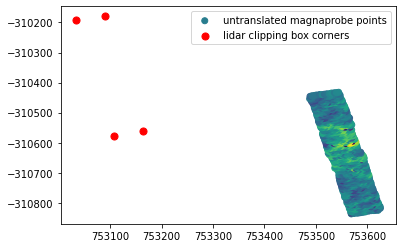

In [37]:
# inspect untranslated Magnaprobe data as an example
plt.scatter(mp_northpolar[0], mp_northpolar[1], c = snow_meters, label = "untranslated magnaprobe points")
plt.scatter(corners_northpolar[0], corners_northpolar[1], s=50, c='red', label = "lidar clipping box corners")
plt.legend()

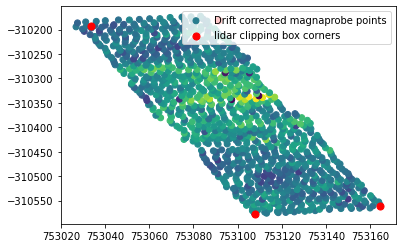

In [38]:
# Check that Magnaprobe drift correction worked

plt.scatter(mp_x_dc, mp_y_dc, c = snow_meters, label = 'Drift corrected magnaprobe points')
plt.scatter(corners_northpolar[0], corners_northpolar[1], s=50, c='red', label = "lidar clipping box corners")
plt.legend()

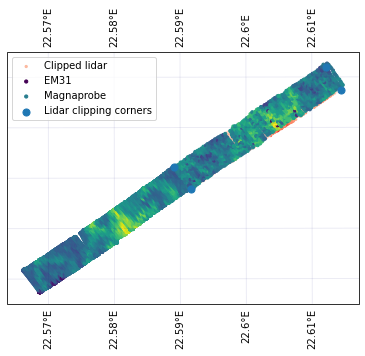

In [39]:
# check alignmnent for all datasets - clipped lidar, EM31, Magnaprobe

fig = plt.figure(figsize=(16*cm,16*cm))
ax1= fig.add_subplot(111, projection=ccrs.NorthPolarStereo(central_longitude=22.5, true_scale_latitude=70))

ax1.scatter(lidar_in_patch[:,0], lidar_in_patch[:,1], c = elevation_in_patch, cmap="Reds",
            transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "Clipped lidar", s = 5 )

ax1.scatter(em31_x_dc, em31_y_dc, c = em31_total_thickness,
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
            label = "EM31", s = 10 )

ax1.scatter(mp_x_dc, mp_y_dc, c = snow_meters,
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
            label = "Magnaprobe", s = 10)

ax1.scatter(corners_northpolar[0], corners_northpolar[1], s=50,
            transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "Lidar clipping corners")



ax1.legend()
ax1.gridlines(color=[0.1, 0.1, 0.5, 0.1], draw_labels=True, auto_inline=True)

### Extract snow radar observations with nearby Magnaprobe observations

This is so we can perform a best-possible check of how snow radar and magnaprobe observatios compare, redcing any confounding factors.

In [59]:
from scipy.spatial import distance

# define a small function to find the closest nodes in an array to a given input node
def closest_node(node, nodes):
    #print(distance.cdist([node], nodes).argmin())
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

In [60]:
# create a 2D array from magnaprobe X and Y data

mp_dc_xy = np.array([mp_x_dc, mp_y_dc])
mp_dc_xy.shape

(2, 1046)

In [61]:
# set up a matrix of distances between coordinate pairs
dist_matrix = distance.cdist(np.transpose(snowradar_northpolar), np.transpose(mp_dc_xy), 'euclidean')

In [62]:
# filter set to 5 units (in this case meters), finding any radar obs 5m or less from a magnaprobe obs
located_obs = np.where(dist_matrix <= 3.2)

In [63]:
# get only unique magnaprobe point indices, we want one (the closest) MP point per radar point
uniq_obs = np.unique(located_obs[0])

In [64]:
len(uniq_obs)

60

In [65]:
uniq_obs

array([ 61,  62,  63,  64,  65,  66,  67,  68,  69,  72,  73,  74,  75,
        76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124], dtype=int64)

In [66]:
located_obs[0]

array([ 61,  62,  63,  64,  64,  65,  65,  66,  67,  68,  69,  72,  73,
        74,  75,  76,  77,  77,  78,  80,  80,  81,  81,  82,  83,  83,
        84,  84,  85,  86,  86,  87,  87,  88,  89,  89,  90,  91,  91,
        92,  93,  94,  94,  95,  96,  97,  98,  98,  99, 100, 101, 102,
       103, 103, 104, 106, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 122, 123, 124],
      dtype=int64)

In [67]:
snowradar_in_mp_x = snowradar_northpolar[0][uniq_obs]
snowradar_in_mp_y = snowradar_northpolar[1][uniq_obs]
snowradar_depth_in_mp = snowdepth_radar[uniq_obs]
snowradar_cut_xy = np.array([snowradar_in_mp_x, snowradar_in_mp_y])

In [70]:
dist_matrix = distance.cdist(np.transpose(snowradar_cut_xy), np.transpose(mp_dc_xy), 'euclidean')
located_obs = np.where(dist_matrix <= 3.2)
uniq_mp_obs = np.unique(located_obs[1])
uniq_mp_obs.size

63

In [71]:
mp_radar_matches_x = mp_x_dc[uniq_mp_obs]
mp_radar_matches_y = mp_y_dc[uniq_mp_obs]
mp_radar_matches_z = snow_meters[uniq_mp_obs]

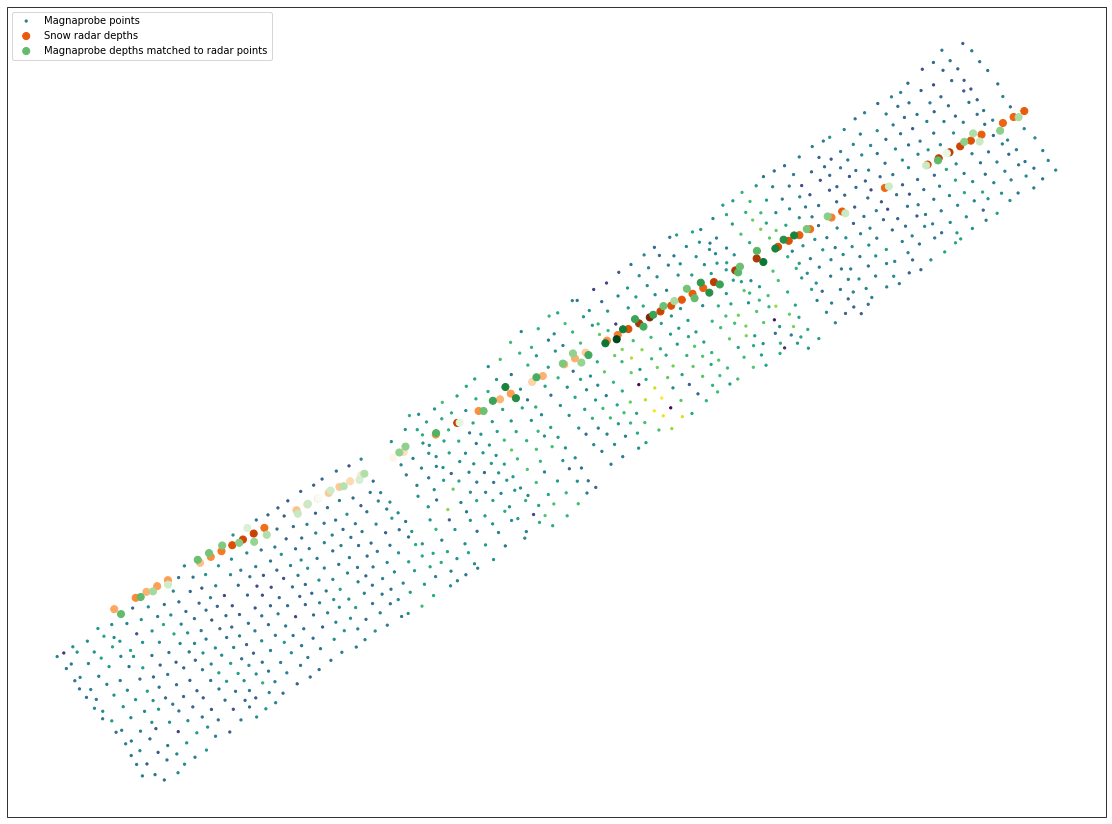

In [72]:
# check alignmnent

fig = plt.figure(figsize=(50*cm,50*cm))
ax1= fig.add_subplot(111, projection=ccrs.NorthPolarStereo(central_longitude=22.5, true_scale_latitude=70))

ax1.scatter(mp_x_dc, mp_y_dc, c = snow_meters, s=5,
           transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
            label = "Magnaprobe points" )

ax1.scatter(snowradar_in_mp_x, snowradar_in_mp_y, c = snowradar_depth_in_mp, s=50, cmap='Oranges',
            transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "Snow radar depths")

ax1.scatter(mp_radar_matches_x, mp_radar_matches_y, c = mp_radar_matches_z, s=50, cmap='Greens',
            transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
           label = "Magnaprobe depths matched to radar points")


ax1.legend()